# Scraping Toots about IKEA from mastodon.world

This notebook is a bit more advanced. It will only come with little explanations regarding the code. If you need more guidance, please refer to the notebook Mastodon_Migros_Prototype. Also, this notebook is a bit more interactive, using the input function by Python.

## Load libraries and modules

In [2]:
import json
import requests
import pandas as pd
import re
import nltk
import itertools
import collections
import matplotlib.pyplot as plt

In [3]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [4]:
from textblob import TextBlob

### To store the DataFrame in a separate folder (name it data), and to read it in when needed
to avoid scraping over and over again after restart of Jupyter Notebook

In [5]:
from pathlib import Path

In [6]:
data_folder = Path("../data")
csv_path = data_folder / "mastodon_ikea.csv"

## Preparation - Defining hashtag and URL for requests, set timeframe

In [5]:
def ask_for_hashtag():

    hashtag = input("Enter the hashtag which you would like to search: ")
    return hashtag

In [6]:
def build_url():

    user_hashtag = ask_for_hashtag()
    cleaned_hashtag = user_hashtag.lower()

    url = f'https://mastodon.world/api/v1/timelines/tag/{cleaned_hashtag}'

    return url

In [7]:
def ask_for_starting_date():

    user_starting_date = input("Please enter the date you would like to start scraping. "
                          "Tip: Depending on the hashtag, start with a short time period. "
                          "Use the YYYY-MM-DD notation: ")

    return user_starting_date

## Scraping the toots

The following code now actually fetches recent posts with a specific hashtag from Mastodon and stores them in a Pandas DataFrame.

In [8]:
def scraping_toots():
    
    params = {'limit': 40} #one can only fetch 40 posts at once
    
    URL = build_url()
    print(URL)
    
    date = ask_for_starting_date()
    since = pd.Timestamp(f'{date} 00:00:00', tz='UTC')
    print(since)
    
    is_end = False
    
    
    results = []
    chunk_no = 1
    
    while True:
    
        try:
            response = requests.get(URL, params=params)
            print("STATUS OF YOUR SCRAPING: chunk number", chunk_no)
            chunk_no += 1
            response.close()
        except:
            print("An error occured." 
                  "The http status code is {}".format(response.status_code))
        
        toots = json.loads(response.text)
    
        if len(toots) == 0:
            print("There were no toots returned. " 
                  "Check for spelling or use another hashtag")
            break
        
        for toot in toots:
            timestamp = pd.Timestamp(toot['created_at'], tz='utc')
            if timestamp <= since:
                is_end = True
                break
                
            results.append(toot)
        
        if is_end:
            break
        
        max_id = toots[-1]['id']
        params['max_id'] = max_id
    
        
    df_hashtag = pd.DataFrame(results)
    
    return df_hashtag

In [9]:
df = scraping_toots()

Enter the hashtag which you would like to search:  Ikea


https://mastodon.world/api/v1/timelines/tag/ikea


Please enter the date you would like to start scraping. Tip: Depending on the hashtag, start with a short time period. Use the YYYY-MM-DD notation:  2024-01-01


2024-01-01 00:00:00+00:00
STATUS OF YOUR SCRAPING: chunk number 1
STATUS OF YOUR SCRAPING: chunk number 2
STATUS OF YOUR SCRAPING: chunk number 3
STATUS OF YOUR SCRAPING: chunk number 4
STATUS OF YOUR SCRAPING: chunk number 5
STATUS OF YOUR SCRAPING: chunk number 6
STATUS OF YOUR SCRAPING: chunk number 7
STATUS OF YOUR SCRAPING: chunk number 8
STATUS OF YOUR SCRAPING: chunk number 9
STATUS OF YOUR SCRAPING: chunk number 10
STATUS OF YOUR SCRAPING: chunk number 11
STATUS OF YOUR SCRAPING: chunk number 12
STATUS OF YOUR SCRAPING: chunk number 13
STATUS OF YOUR SCRAPING: chunk number 14
STATUS OF YOUR SCRAPING: chunk number 15
STATUS OF YOUR SCRAPING: chunk number 16
STATUS OF YOUR SCRAPING: chunk number 17
STATUS OF YOUR SCRAPING: chunk number 18
STATUS OF YOUR SCRAPING: chunk number 19
STATUS OF YOUR SCRAPING: chunk number 20
STATUS OF YOUR SCRAPING: chunk number 21
STATUS OF YOUR SCRAPING: chunk number 22


## Results and DF

In [10]:
df.shape

(851, 24)

In [11]:
df.columns

Index(['id', 'created_at', 'in_reply_to_id', 'in_reply_to_account_id',
       'sensitive', 'spoiler_text', 'visibility', 'language', 'uri', 'url',
       'replies_count', 'reblogs_count', 'favourites_count', 'edited_at',
       'content', 'reblog', 'account', 'media_attachments', 'mentions', 'tags',
       'emojis', 'card', 'poll', 'application'],
      dtype='object')

## Cleaning up the data

In [12]:
def account_id_column(dataframe):
    dataframe['account_id'] = dataframe['account'].apply(lambda x: x['id'])

    return dataframe

In [13]:
def tag_name_column(dataframe):

    dataframe = dataframe.explode("tags").reset_index()
    dataframe["tag_name"] = dataframe["tags"].apply(lambda y: y['name'])

    return dataframe

In [14]:
def extract_text_from_html(html):

    """Parsing a string which is in html code to extract actual text.

    Parameters
    ----------
    html : string
        String that stores the content of the post (or any text) in html.

    Returns
    -------
    soup.get_text() : string
        A string with the actual text, without any html tags etc.
    """
    
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text()

In [15]:
def parsed_content_column(dataframe):

    dataframe["extracted_content"] = dataframe["content"].apply(extract_text_from_html)

    return dataframe

In [16]:
def choose_languages():

    defined_languages = False
    
    while True: 
        languages = input("Which languages should the posts have? "
                          "Leave the field empty to use the default which is English. "
                          "Otherwise refer to the List of ISO 639 language codes. "
                          "Use the following way to write all of them down: en sv fr. ") or "en"
        languages = languages.split(" ")
        print("Chosen languages: ", languages)
        
        answer = input("If these are the languages you want to use, type yes: ")
        
        if answer.lower() == "yes":
            defined_languages = True
            
            print("Chosen languages are: ", languages)
            break
        
    return languages

In [17]:
def cleaning_data(dataframe):

    dataframe = account_id_column(dataframe)
    dataframe = tag_name_column(dataframe)
    dataframe = parsed_content_column(dataframe)

    
    language_competences = ["en", "de", "fr", "sv"]
    print("The following languages are used: ", language_competences)
    language_answer = input("If you want to use the same languages, type yes, else type no: ")
    
    if language_answer.lower() != "yes":
        language_competences = choose_languages()
    
    new = dataframe[dataframe['language'].isin(language_competences)]

    
    df_small = new[[
    "index", 
    "id", 
    "created_at", 
    "language", 
    "account_id", 
    "extracted_content", 
    "tag_name"]]

    return df_small

In [18]:
clean_df = cleaning_data(df)

The following languages are used:  ['en', 'de', 'fr', 'sv']


If you want to use the same languages, type yes, else type no:  yes


In [19]:
clean_df

,index,id,created_at,language,account_id,extracted_content,tag_name
0,0,113477263268066882,2024-11-13T19:20:23.000Z,sv,110853048098304921,▸ Det svenska språket ska bantas ner på Ikea i...,sverige
1,0,113477263268066882,2024-11-13T19:20:23.000Z,sv,110853048098304921,▸ Det svenska språket ska bantas ner på Ikea i...,finland
2,0,113477263268066882,2024-11-13T19:20:23.000Z,sv,110853048098304921,▸ Det svenska språket ska bantas ner på Ikea i...,ikea
24,2,113474006887221276,2024-11-13T05:21:37.000Z,de,111204922380677786,Maßmöbel erfreuen sich zunehmender Beliebtheit...,ratgeber
25,2,113474006887221276,2024-11-13T05:21:37.000Z,de,111204922380677786,Maßmöbel erfreuen sich zunehmender Beliebtheit...,ikea
...,...,...,...,...,...,...,...
3294,848,111687735356166528,2024-01-02T18:19:50.000Z,en,110253184226848717,Man confesses to reading the instructions#IKEA...,lifestyle
3295,848,111687735356166528,2024-01-02T18:19:50.000Z,en,110253184226848717,Man confesses to reading the instructions#IKEA...,madeupnews
3296,848,111687735356166528,2024-01-02T18:19:50.000Z,en,110253184226848717,Man confesses to reading the instructions#IKEA...,satire
3299,850,111682466289088824,2024-01-01T19:59:52.000Z,en,109943094477399312,#IKEA ist doch nicht mehr ganz dicht?! Oh mome...,ikea


In [21]:
clean_df.to_csv(csv_path)

## Having a closer look at the hashtags

In [7]:
#reading in the csv file, uncomment if not needed
clean_df = pd.read_csv(csv_path)

In [8]:
tags_count = clean_df["tag_name"].value_counts().reset_index()
tags_count.head(10)

,tag_name,count
0,ikea,724
1,blahaj,22
2,diy,17
3,furniture,16
4,tradfri,15
5,homeassistant,15
6,smarthome,14
7,arte,13
8,zigbee,11
9,nachhaltigkeit,11


In [8]:
sustainability = ["greenwashing", "klimaschutz", "klima", "umwelt", 
                  "umweltschutz", "nachhaltig", "nachhaltigkeit", "tier", 
                  "tierschutz", "recycling", "vegan", "environmental", 
                  "greenpeace", "deforestation", "environment",
                 "sustainability", "righttorepair", "arte"]

In [9]:
df_sustainable = clean_df[clean_df["tag_name"].isin(sustainability)]

In [10]:
# explode() results in almost exact copies of some rows (except for the tag name)
# we only need the content once, to avoid duplicates utilizing drop_duplicates
sustainable = df_sustainable.drop_duplicates("extracted_content")["extracted_content"].to_list()
for post in sustainable[:10]:
    print(post)
    print("---------------------------------------------")

Ready for a joke that isn't one? No worries, #ikea got you covered.#sustainability #onlineshopping
---------------------------------------------
Doe mee aan de drukcampagne op Ikea, voor het stoppen met leer.We komen terug, met nog veel meer!Tot ze stoppen 🔥.Join the pressure campaign on Ikea, for quitting leather.We'll be back, with much more!Until they stop 🔥.https://groups.animalrebellion.nl/events/3e4730aa-09bd-498e-8a62-afbc1230a1e3#leer #leather #ikea #plantbased #sustainability
---------------------------------------------
@rootsandcalluses Irgendwie bin ich nicht überrascht. Gibt es bei #IKEA überhaupt wertige Produkte?Ich beispielsweise fahre mit gebrauchtem Ceracron, Friesland, Melitta, Rosenthal, Thomas z.B. bisher sehr gut. #Keramik #Nachhaltigkeit #Porzellan #Steingut
---------------------------------------------
Ikea mal nen Brief schicken und nett nachfragen ob sie bitte nicht Europas letzten Urwald fällen mögen...https://act.greenpeace.de/offenerbrief-ikea-g#greenpeace 

In [11]:
len(sustainable)

46

## Sentiment analysis of toots

Sentiment analysis helps determine attitudes within text data about a particular subject by assigning polarity scores that range from -1 to 1. Scores closer to 1 indicate positive sentiment, while those near -1 indicate negative sentiment.

The following uses TextBlob to perform sentiment analysis on Mastodon toots. 

In [12]:
#helper function to remove urls from toots
def remove_url(txt):
    """Replace URLs found in a text string with nothing.
    It will remove the URL from the string.

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

In [37]:
def plot_polarity_scores(polarity_dataframe):
    plt.figure(figsize=(10, 6))
    plt.hist(polarity_dataframe["polarity"], bins=100, color='blue', edgecolor='black', alpha=0.7)
    
    plt.title("Distribution of Polarity Scores")
    plt.xlabel("Polarity Score")
    plt.ylabel("Frequency")
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label='Neutral Score')
    
    plt.legend()
    plt.show()

In [28]:
def sentiment_with_textblob(dataframe):

    # prepare with: store toots in list, drop duplicates
    list_toots = dataframe.drop_duplicates("extracted_content")["extracted_content"].to_list()
    print("The list contains {} toots".format(len(list_toots)))
    
    # dropping urls
    toots_no_urls = [remove_url(toot) for toot in list_toots]

    # start sentiment analysis, output: TextBlob object
    sentiment_toots = [TextBlob(toot) for toot in toots_no_urls]

    # accessing polarity/ subjectivity scores directly, storing together with the toot
    sentiment_values = [[toot.sentiment.polarity, 
                         toot.sentiment.subjectivity, 
                         str(toot)] for toot in sentiment_toots]
    
    # for better processing store result in DF
    sentiment_df = pd.DataFrame(sentiment_values, 
                                columns=["polarity", "subjectivity", "toot"])

    return sentiment_toots, sentiment_df

### Sustainability Toots Written in English

In [29]:
df_sustainable_en = df_sustainable[df_sustainable["language"] == "en"]

In [30]:
sentiment_toots_sustainability, sentiment_df_sustainability = sentiment_with_textblob(df_sustainable_en)

The list contains 16 toots


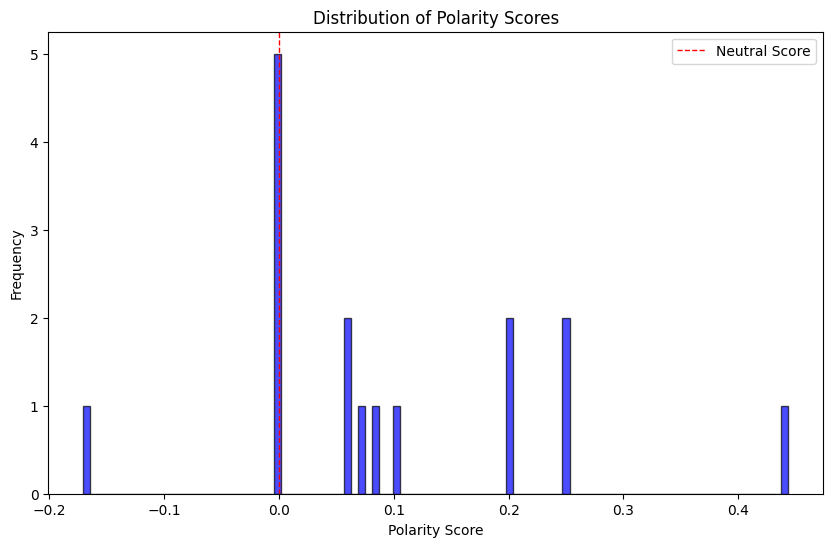

In [31]:
plot_polarity_scores(sentiment_df_sustainability)

There were 16 toots written in English around the topic of sustainability, utilizing the given list of sustainability terms. Most of them are rather critical and one might have expected rather negative polarity values. But that is not what we observe.

Let's learn a bit more about TextBlob:

TextBlob’s sentiment analysis relies on a lexicon-based approach, meaning it uses a pre-built dictionary of words associated with predefined polarity (positivity or negativity) and subjectivity scores. Here’s how it works and when the polarity score might lean toward -1 (indicating negativity):

    Polarity Scoring:
        TextBlob examines each word in the text and matches it to a lexicon of words where each has a polarity score between -1 (negative) and 1 (positive).
        For example, words like "excellent" or "love" have positive scores, while words like "terrible" or "hate" have negative scores.
        TextBlob calculates an overall score by summing the individual polarity scores of each word and then averaging it over the length of the text.

    Modifiers and Negation:
        TextBlob can adjust scores based on modifiers (e.g., "very good" has a stronger positive score than just "good").
        Negations like "not" can reverse or soften polarity (e.g., "not bad" becomes a weakly positive score instead of negative).

    When Polarity Goes Toward -1:
        A polarity score will lean toward -1 if the text contains predominantly negative words and phrases (e.g., "terrible experience," "hate this," "awful service").
        Strong negative words, repeated negative expressions, or even a few highly negative terms can push the score further negative.

    Limitations:
        Since TextBlob’s analysis is lexicon-based, it might struggle with sarcasm, idioms, or context-specific meanings where words deviate from standard sentiment (e.g., "sick" as slang for something positive).

**Some Observation**

Let's pick a rather obvious toot, which is currently on position 5 in our result:

"Buying #IKEA means supporting rampant #deforestation enforced by #mafia leaving a trail of murdered environmental activists. #boycottIKEA Wer IKEA kauft, unterstützt die zügellose Abholzung, die von der Mafia durchgesetzt wird und eine Spur von ermordeten Umweltaktivisten hinterlässt. "

It has a polarity score of 0.25 which seems too high, given the critical text.

**Possible Fix**

Something, one could try is to seperate the English from the German part, maybe the model gets cunfused by it. First, the result from above. Second the result with just the English snippet.

In [33]:
sentiment_toots_sustainability[4].polarity, sentiment_toots_sustainability[4]

(0.25,
 TextBlob("Buying #IKEA means supporting rampant #deforestation enforced by #mafia leaving a trail of murdered environmental activists. #boycottIKEA Wer IKEA kauft, unterstützt die zügellose Abholzung, die von der Mafia durchgesetzt wird und eine Spur von ermordeten Umweltaktivisten hinterlässt. "))

In [31]:
TextBlob("Buying #IKEA means supporting rampant #deforestation enforced by #mafia leaving a trail of murdered environmental activists.").sentiment.polarity

0.25

**Result**

It's the same result. Probably because words like buying, means, leaving, trail etc are rather neutral. Words like supporting and environmental, and maybe activists as well might be rather positive connotated. So in the end and overall, the polarity score ends up where it is now: 0.25

Solution: try alternative libraries.

### All Toots Written in English

One thing which might still be interesting, is the overall sentiment of all English posts. Let's have a look.

In [34]:
df_en = clean_df[clean_df["language"] == "en"]

In [35]:
sentiment_toots_en, sentiment_df_en = sentiment_with_textblob(df_en)

The list contains 430 toots


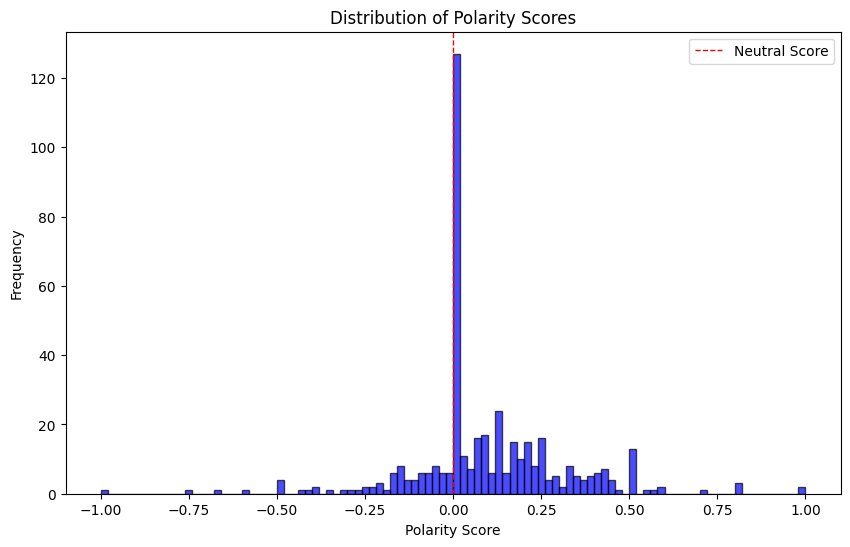

In [38]:
plot_polarity_scores(sentiment_df_en)

**Let's have a look at the ten toots with most negative polarity scores**

In [39]:
sorted_polarity = sentiment_df_en.sort_values("polarity")

In [40]:
negative = sorted_polarity.iloc[:10]
negative

,polarity,subjectivity,toot
293,-1.000000,1.000000,Do people go to IKEA just to browse? I wanna g...
424,-0.750000,1.000000,4h après : c’est terminé 🤯 #ikea #ikeahemnes
275,-0.666667,1.000000,"Achievement of the day. Yes, I cheated with th..."
279,-0.600000,0.800000,"@WilliamKretschmer Fucking #Ikea, it was suppo..."
37,-0.500000,0.400000,#IKEA #Fail I understand the need for random a...
18,-0.500000,1.000000,Went to #IKEA today and boy are they killing i...
107,-0.500000,1.000000,#weird #IKEA #jdvance
210,-0.500000,1.000000,@andrewbrent There's always #IKEA. Have I jus...
375,-0.433333,0.600000,Dramatic shark child #IKEA #Shark #Plushie
187,-0.416667,0.666667,#Pathetic #bigots are #crying over #IKEA’s #ra...


In [41]:
negative_toots = negative["toot"].to_list()
for toot in negative_toots:
    print(toot)
    print("----------------------------------------")

Do people go to IKEA just to browse? I wanna get stuff from IKEA but I don’t have a car, so I kinda wanna take a train to IKEA and then order what I want online. Is that a thing?(I’m referring to IKEA in the US. Yes, I can take a train to IKEA where I am in the US. Shocking ik)#ikea #transit #publicTransit
----------------------------------------
4h après : c’est terminé 🤯 #ikea #ikeahemnes
----------------------------------------
Achievement of the day. Yes, I cheated with the handles cuz the screws were impossible to screw in. #ikea
----------------------------------------
@WilliamKretschmer Fucking #Ikea, it was supposed to be a bookshelf
----------------------------------------
#IKEA #Fail I understand the need for random audit in self serving payment, but claiming that someone is coming to help is a bit tongue in cheek. I don't need help for a problem you've just caused your customer, Ikea, you should apologize and beg for the customer's comprehension.
----------------------------

**Result**
 
These toots, which have the most negative polarity score - which means that they indicate a negative sentiment - are in fact not that negative (7/10). Some are critical, but some are totally okay or address when someone has finished building a IKEA furniture. And the one post that even has -1 is just about if there are people going to IKEA to browse. Some use a strong language, but are not negatively connoted ("Went to #IKEA today and boy are they killing it for #Halloween. All kinds of creepy #candy decorations, we got some #FreeCandy and even saw some haunted hotdog buns.", "#Pathetic #bigots are #crying over #IKEA’s #rainbow #Pride #charity #cake. IKEA has long #supported #LGBTQ+ folks. #Women #Transgender #LGBTQ #LGBTQIA #Allies #Pride #PrideMonth #Representation #Culture ").

So, in the end be careful with the result. Maybe a different library will achieve better results, which would be a future step. Another step is to find out, where TextBlob is working well - maybe it is just the way posts are written in, so due to the special format/ style etc..
